<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://goo.gl/rvvZiR).**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

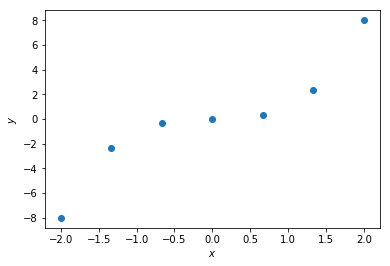

In [2]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график.

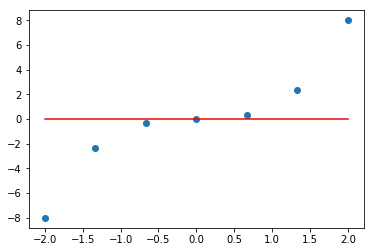

In [3]:
y_mean = np.mean(y)
plt.scatter(X, y)
plt.plot((-2, 2), (y_mean, y_mean), color='red');

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

In [4]:
y1_left = np.mean(y[X<0])
y1_right = np.mean(y[X>=0])

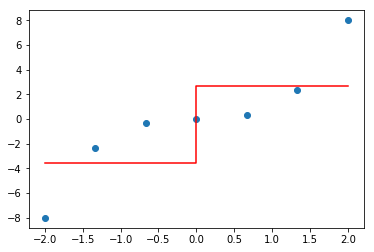

In [5]:
plt.scatter(X, y)
plt.plot((-2, 0, 0, 2), (y1_left, y1_left, y1_right, y1_right), color='red');

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [6]:
def regression_var_criterion(X, y, t):
    y_left = y[X<t]
    y_right = y[X>=t]
    Q = np.var(y) - len(y_left)/len(y)*np.var(y_left)-len(y_right)/len(y)*np.var(y_right)
    return Q

In [7]:
#dx = 1/(len(y))*np.sum((y - np.mean(y))**2)

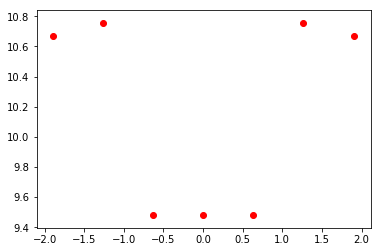

In [8]:
for t in np.linspace(-1.9, 1.9, 7):
    plt.scatter(t, regression_var_criterion(X, y, t), color='red')

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- <u>Нет</u>


Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

In [9]:
y_left_left = np.mean(y[X<-1.5])
y_left_right = np.mean(y[(X>=-1.5) & (X<0)])

In [10]:
y_right_left = np.mean(y[(X>=0) & (X<1.5)])
y_right_right = np.mean(y[X>=1.5])

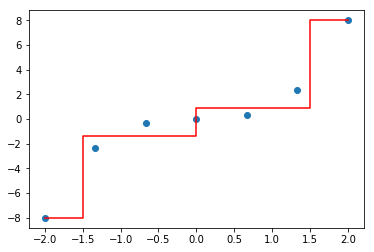

In [11]:
plt.scatter(X, y)
plt.plot((-2, -1.5, -1.5, 0, 0, 1.5, 1.5, 2), \
         (y_left_left, y_left_left, y_left_right, y_left_right, y_right_left, y_right_left, y_right_right, y_right_right), \
         color='red');

**<font color='red'>Вопрос 2.</font> Из скольки отрезков состоит график, изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- <u>7</u>
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [12]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [13]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах", а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`.

In [14]:
df['age_years'] = round(df['age'] / 365.25).astype('int')
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
id,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48


In [15]:
df_dum = pd.get_dummies(df, columns=['cholesterol', 'gluc'])
df_dum.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,age_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,0,0,1,0,50,1,0,0,1,0,0
1,20228,1,156,85.0,140,90,0,0,1,1,55,0,0,1,1,0,0
2,18857,1,165,64.0,130,70,0,0,0,1,52,0,0,1,1,0,0
3,17623,2,169,82.0,150,100,0,0,1,1,48,1,0,0,1,0,0
4,17474,1,156,56.0,100,60,0,0,0,0,48,1,0,0,1,0,0


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [16]:
y = df_dum['cardio']
X = df_dum.drop('cardio', axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=17)

In [17]:
X.shape, y.shape, X_train.shape, X_valid.shape

((70000, 16), (70000,), (49000, 16), (21000, 16))

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [18]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17).fit(X_train, y_train)

In [19]:
export_graphviz(tree, out_file='../../img/cardio_tree.dot', feature_names=X.columns, filled=True)

In [20]:
# import os
# os.environ["PATH"] += os.pathsep + 'D:\Games\Anaconda\pkgs\graphviz-2.38.0-4\Library\bin\graphviz'

In [21]:
import pydot

(graph,) = pydot.graph_from_dot_file('../../img/cardio_tree.dot')
graph.write_png('../../img/cardio_tree.png')

True

In [23]:
!dot -Tpng '../Work/DataScience/mlcourse_open/img/cardio_tree.dot' -o '../Work/DataScience/mlcourse_open/img/cardio_tree.png'

'D:\Games' is not recognized as an internal or external command,
operable program or batch file.
The system cannot find the path specified.


<img src='../../img/cardio_tree.png'/>

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- <u>age, ap_hi, chol=3</u>

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [21]:
tree.score(X_valid, y_valid)

0.72128571428571431

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [22]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=17), tree_params, cv=5, n_jobs=-1)

In [23]:
%%time
tree_grid.fit(X_train, y_train);

Wall time: 12 s


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [24]:
tree_grid.best_score_, tree_grid.best_params_

(0.73195918367346935, {'max_depth': 6})

In [25]:
tree_grid.score(X_valid, y_valid)

0.72580952380952379

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

In [26]:
from sklearn.model_selection import cross_val_score
score=[]
for d in range(2, 11):
    tree_depth = DecisionTreeClassifier(random_state=17, max_depth=d)
    score.append(np.mean(cross_val_score(tree_depth, X_train, y_train, cv=5)))

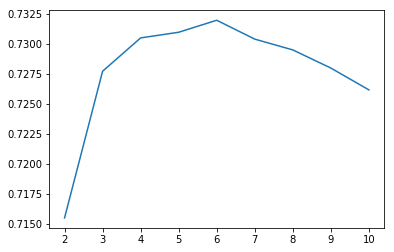

In [27]:
plt.plot(range(2, 11), score);

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

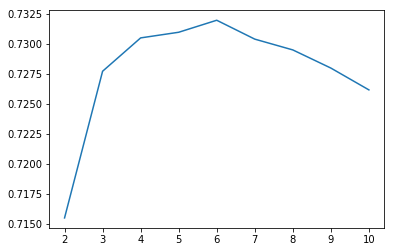

In [28]:
plt.plot(range(2, 11), tree_grid.cv_results_['mean_test_score']);

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева четкий пик, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке?**
- да, да
- <u>да, нет</u>
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках.

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- <u>Верхнее артериальное давление от 140 до 160 (мм рт.ст.)</u>
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [31]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700,53.303157
std,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003,6.760171
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,30.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,48.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,54.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,65.000000


In [64]:
df1 = df.loc[:,['gender', 'ap_hi', 'cholesterol', 'smoke', 'age_years', 'cardio']]

In [65]:
df1['age_1'] = ((df1['age_years']>=45) & (df1['age_years']<50)).astype('int')

In [66]:
df1['age_2'] = ((df1['age_years']>=50) & (df1['age_years']<55)).astype('int')

In [67]:
df1['age_3'] = ((df1['age_years']>=55) & (df1['age_years']<60)).astype('int')

In [69]:
df1['age_4'] = ((df1['age_years']>=60) & (df1['age_years']<65)).astype('int')

In [71]:
df1['ap_hi_1'] = ((df1['ap_hi']>=120) & (df1['ap_hi']<140)).astype('int')

In [73]:
df1['ap_hi_2'] = ((df1['ap_hi']>=140) & (df1['ap_hi']<160)).astype('int')

In [74]:
df1['ap_hi_3'] = ((df1['ap_hi']>=160) & (df1['ap_hi']<180)).astype('int')

In [77]:
df1 = pd.get_dummies(df1, columns=['cholesterol'])

In [87]:
df1['male'] = pd.factorize(df1['gender'], sort=True)[0]

In [88]:
df1.head()

,gender,ap_hi,smoke,age_years,cardio,age_1,age_2,age_3,age_4,ap_hi_1,ap_hi_2,ap_hi_3,cholesterol_1,cholesterol_2,cholesterol_3,male
id,,,,,,,,,,,,,,,,
0,2,110,0,50,0,0,1,0,0,0,0,0,1,0,0,1
1,1,140,0,55,1,0,0,1,0,0,1,0,0,0,1,0
2,1,130,0,52,1,0,1,0,0,1,0,0,0,0,1,0
3,2,150,0,48,1,1,0,0,0,0,1,0,1,0,0,1
4,1,100,0,48,0,1,0,0,0,0,0,0,1,0,0,0


In [92]:
y = df1['cardio']
X = df1.drop(['gender', 'ap_hi', 'age_years', 'cardio'], axis=1)

In [118]:
tree_bin = DecisionTreeClassifier(max_depth=3, random_state=17).fit(X, y)

In [119]:
export_graphviz(tree_bin, out_file='../../img/tree_bin.dot', feature_names=X.columns, filled=True)

In [120]:
import pydot

(graph,) = pydot.graph_from_dot_file('../../img/tree_bin.dot')
graph.write_png('../../img/tree_bin.png')

True

<img src='../../img/tree_bin.png' />

In [121]:
tree_bin.feature_importances_

array([  5.36170201e-05,   0.00000000e+00,   1.11066778e-04,
         3.19214730e-04,   0.00000000e+00,   0.00000000e+00,
         5.80596608e-01,   2.48590650e-01,   0.00000000e+00,
         4.37410163e-04,   1.69891434e-01,   0.00000000e+00])

In [122]:
X.head()

,smoke,age_1,age_2,age_3,age_4,ap_hi_1,ap_hi_2,ap_hi_3,cholesterol_1,cholesterol_2,cholesterol_3,male
id,,,,,,,,,,,,
0,0,0,1,0,0,0,0,0,1,0,0,1
1,0,0,0,1,0,0,1,0,0,0,1,0
2,0,0,1,0,0,1,0,0,0,0,1,0
3,0,1,0,0,0,0,1,0,1,0,0,1
4,0,1,0,0,0,0,0,0,1,0,0,0


In [124]:
df2 = df1.loc[df1['age_years']>=45,:]

In [127]:
df2 = df2.loc[df2['age_years']<65,:]

In [128]:
df2 = df2.loc[df2['ap_hi']>=120,:]

In [129]:
df2 = df2.loc[df2['ap_hi']<180,:]

In [132]:
y2 = df2['cardio']
X2 = df2.drop(['gender', 'ap_hi', 'age_years', 'cardio'], axis=1)

In [133]:
tree_bin2 = DecisionTreeClassifier(max_depth=3, random_state=17).fit(X2, y2)

In [134]:
export_graphviz(tree_bin2, out_file='../../img/tree_bin2.dot', feature_names=X2.columns, filled=True)

In [135]:
(graph,) = pydot.graph_from_dot_file('../../img/tree_bin2.dot')
graph.write_png('../../img/tree_bin2.png')

True

<img src='../../img/tree_bin2.png' />